## **IMPORTS**

In [ ]:
import nltk
import re

In [ ]:
import tweepy
import pandas as pd
import time
import datetime
import numpy

##**TWITTER API**

In [ ]:
credentials_df = pd.read_csv('credentials.csv',header=None,names=['name','key'])

In [ ]:
consumer_key = credentials_df.loc[credentials_df['name']=='consumer_key','key'].iloc[0]
consumer_secret = credentials_df.loc[credentials_df['name']=='consumer_secret','key'].iloc[0]
access_token = credentials_df.loc[credentials_df['name']=='access_token','key'].iloc[0]
access_token_secret = credentials_df.loc[credentials_df['name']=='access_secret','key'].iloc[0]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

##**TWEEPY // SCRAPING TWEETS**

In [ ]:
start_date = datetime.datetime(2021, 6, 12, 00, 00, 00)
end_date = datetime.datetime(2021, 6, 20, 00, 00, 00)
text_list = ["DOGE","Dogecoin","doge"]
total = pd.DataFrame()
for text in range(0,len(text_list)):
  text_query = text_list[text]+"-filter:retweets"
  # Creation of query method using parameters
  tweets = tweepy.Cursor(api.search, q = text_query, tweet_mode = 'extended', lang= "en", result_type = 'popular',count = 1000 ).items()
      # List comprehension pulling chosen tweet information from tweets iterable object
    # Add or remove tweet information you want in the below list comprehension
  tweets_list = [[tweet.full_text, tweet.created_at, tweet.retweet_count, tweet.user.verified, tweet.user.name, tweet.user.followers_count, 
                  tweet.user.friends_count, tweet.user.favourites_count, tweet.user.created_at, tweet.user.statuses_count, tweet.coordinates,
                    tweet.place, tweet.lang, tweet.source, tweet.is_quote_status,] for tweet in tweets ]
  
  tweets_df = pd.DataFrame(tweets_list,columns=['Tweet Text', 'Tweet Datetime','Retweets', 'User Verified Status','Twitter Username', 'Users Following Count','Number users this account is following',
                                                'Users Number of Likes','Account Created Time', 'Users Tweet Count', 'Tweet Coordinates', 'Place Info',
                                                'Language', 'Source','Quote Status Bool'])
  if text==0:
    total = tweets_df
  else:
    total = pd.concat([total,tweets_df])

    
total.to_csv('tweets.csv', sep=',', index = False)

# another dataset
for text in range(0,len(text_list)):
  text_query = text_list[text]+"-filter:retweets"
  tweets = tweepy.Cursor(api.search, q = text_query, since = start_date, until = end_date, tweet_mode = 'extended', lang= "en", result_type = 'mixed',count = 100).items()
      # List comprehension pulling chosen tweet information from tweets iterable object
    # Add or remove tweet information you want in the below list comprehension
  tweets_list = [[tweet.full_text, tweet.created_at, tweet.retweet_count, tweet.user.verified, tweet.user.name, tweet.user.followers_count, 
                  tweet.user.friends_count, tweet.user.favourites_count, tweet.user.created_at, tweet.user.statuses_count, tweet.coordinates,
                    tweet.place, tweet.lang, tweet.source, tweet.is_quote_status,] for tweet in tweets if tweet.user.followers_count > 500 if tweet.retweet_count > 0]
  tweets_df2 = pd.DataFrame(tweets_list,columns=['Tweet Text', 'Tweet Datetime','Retweets', 'User Verified Status','Twitter Username', 'Users Following Count','Number users this account is following',
                                                'Users Number of Likes','Account Created Time', 'Users Tweet Count', 'Tweet Coordinates', 'Place Info',
                                                'Language', 'Source','Quote Status Bool'])
  total = pd.concat([total,tweets_df2])

total.to_csv('tweets.csv', sep=',', index = False)







In [ ]:
total = pd.read_csv('tweets.csv')
total

In [ ]:
total.drop_duplicates(subset ="Tweet Text",
                     keep = False, inplace = True)

In [ ]:
total.to_csv('tweets.csv', sep=',', index = False)


## **CLEANING TWEETS**

In [ ]:
#clean text 1

def cleanTwt (twt):
  twt = re.sub('[#\$]doge\w*', "Doge", twt) # Removes the # from doge
  twt = re.sub('[#\$]Doge\w*', 'Doge', twt) # Removes the #" from Doge
  twt = re.sub('[#\$]DOGE\w*', 'Doge', twt) # Removes the $" from DOGE
  twt = re.sub('#Dogecoin', 'Doge',twt)
  twt = re.sub('[#\$]btc\w*', "Bitcoin", twt) # 
  twt = re.sub('[#\$]BTC\w*', 'Bitcoin', twt) #
  twt = re.sub('[#\$]BITCOIN\w*', 'Bitcoin', twt) # 
  twt = re.sub('#Bitcoin', 'Bitcoin',twt)
  
  twt = re.sub('#[A-Za-z0-9]+','', twt) #Removes any strings with a #
  twt = re.sub('@[A-Za-z0-9]+','', twt) #Removes @
  twt = re.sub('\$[\SA-Za-z0-9]+','' , twt) 
  twt = re.sub('\\n','',twt) #Removes the \n string
  twt = re.sub('https?:\/\/.+','', twt) #Removes any hyperlinks
  twt = re.sub('[\(\)0-9\,.%\-;\+]+','', twt) 
  return twt

In [ ]:
total['Cleaned Text'] = total['Tweet Text'].apply(cleanTwt)

#tweets_df.to_csv('tweets_cleaned.csv', sep=',', index = False)

In [ ]:
#clean text 2
from nltk.corpus import stopwords
from textblob import Word, TextBlob
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preprocess_tweets(tweet):
    preprocessed_tweet = tweet
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preproceesed_tweet = " ".join(Word(word).lemmatize() for word in preprocessed_tweet.split())
    return preprocessed_tweet

total['Processed Tweet'] = total['Cleaned Text'].apply(preprocess_tweets)

In [ ]:
total.head(5)

,Tweet Text,Tweet Datetime,Retweets,User Verified Status,Twitter Username,Users Following Count,Number users this account is following,Users Number of Likes,Account Created Time,Users Tweet Count,Tweet Coordinates,Place Info,Language,Source,Quote Status Bool,Cleaned Text,Processed Tweet
0,We need $DOGE.,2021-06-18 22:18:40,314,True,David Gokhshtein,395581,1339,64333,2010-07-23 20:33:57,65652,NaN,NaN,en,Twitter for iPhone,False,We need Doge,We need Doge
2,DOGE is needed so people use cryptocurrency as...,2021-06-18 23:06:27,205,True,David Gokhshtein,395581,1339,64333,2010-07-23 20:33:57,65652,NaN,NaN,en,Twitter for iPhone,True,DOGE is needed so people use cryptocurrency as...,DOGE needed people use cryptocurrency intended...
4,I’ll buy more $DOGE. \n\nI’ll buy more $VET.,2021-06-19 08:59:06,137,True,David Gokhshtein,395581,1339,64333,2010-07-23 20:33:57,65652,NaN,NaN,en,Twitter for iPhone,False,I’ll buy more Doge I’ll buy more,I’ll buy Doge I’ll buy
5,I still believe $DOGE 1$🚀🌕💰,2021-06-18 23:47:50,88,True,Keith “KO kid” Berry,15433,998,189288,2010-03-01 09:21:52,19096,NaN,NaN,en,Twitter for iPhone,False,I still believe Doge,I still believe Doge
6,I support you if you support #Doge 💙💎💰🚀,2021-06-18 17:18:51,111,True,Keith “KO kid” Berry,15433,998,189288,2010-03-01 09:21:52,19096,NaN,NaN,en,Twitter for iPhone,False,I support you if you support Doge 💙💎💰🚀,I support support Doge 💙💎💰🚀


## **SENTIMENT ANALYSIS  #1**

In [ ]:
#Create a function to get the subjectivity
def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity
#Create a function to get the polarity
def getPolarity(twt) :
  return TextBlob(twt).sentiment.polarity

#Create 'Polarity'
total['Polarity' ] = total[ 'Processed Tweet'].apply(getPolarity)




In [ ]:
def getAnalysis(score) :
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
total[ 'Analysis'] = total['Polarity'].apply(getAnalysis)


In [ ]:
total.sort_values('Tweet Datetime',inplace= True)


total

,Tweet Text,Tweet Datetime,Retweets,User Verified Status,Twitter Username,Users Following Count,Number users this account is following,Users Number of Likes,Account Created Time,Users Tweet Count,Tweet Coordinates,Place Info,Language,Source,Quote Status Bool,Cleaned Text,Processed Tweet,Polarity,Analysis
155,THE @EZRALEVANT SHOW:\n\nCity of Victoria canc...,2021-06-12 00:00:01,23,True,Rebel News,209409,8989,1690,2015-02-13 23:28:17,52713,NaN,NaN,en,Twitter Web App,False,THE SHOW:City of Victoria cancels Canada Day ...,THE SHOW:City Victoria cancels Canada Day cele...,0.300000,Positive
143,"Siri, what is the currency of El Salvador?\n\n...",2021-06-12 00:01:14,93,True,Yano,49080,9071,21832,2013-01-20 23:10:04,7742,NaN,NaN,en,Twitter for iPhone,False,Siri what is the currency of El Salvador?Bitcoin,Siri currency El Salvador?Bitcoin,0.000000,Neutral
853,"📈💶$2,002,828 $BTC LONGED @$37475.0 [12/06/21 0...",2021-06-12 00:07:20,2,False,WhaleTrades 🐳,93529,0,372,2018-02-28 10:32:22,175404,NaN,NaN,en,Bitmex High Trades,False,📈💶 Bitcoin LONGED @ [// ::]🏪FTX | BTCPERP🗣️It`...,📈💶 Bitcoin LONGED @ [// ::]🏪FTX | BTCPERP🗣️It`...,0.500000,Positive
147,El Salvador has adopted #bitcoin as legal tend...,2021-06-12 00:15:00,51,True,Reuters,23483638,1167,754,2007-03-20 17:46:05,706495,NaN,NaN,en,Twitter Media Studio,False,El Salvador has adopted as legal tender the f...,El Salvador adopted legal tender first country...,0.225000,Positive
141,Bitcoin + #COVID19 + Florida = obvious 2021 he...,2021-06-12 00:15:29,216,True,Eric Feigl-Ding,520441,9001,188059,2009-01-10 11:01:33,50900,NaN,NaN,en,Twitter for iPhone,False,Bitcoin Florida = obvious headline waiting...,Bitcoin Florida = obvious headline waiting hap...,0.056818,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,So guys🤗 @ukiyoefinance public presale begins ...,2021-06-19 23:33:01,41,False,MOON SKY Crypto🇸🇻,23822,377,1494,2011-03-15 18:20:50,625,NaN,NaN,en,Twitter for iPhone,False,So guys🤗 public presale begins on June th UTC...,So guys🤗 public presale begins June th UTC :BN...,0.000000,Neutral
79,Keep selling your bags of $BTC and $ETH to the...,2021-06-19 23:35:38,61,True,David Gokhshtein,395581,1339,64333,2010-07-23 20:33:57,65652,NaN,NaN,en,Twitter for iPhone,False,Keep selling your bags of Bitcoin and to the ...,Keep selling bags Bitcoin Wall Street elites T...,-0.033333,Negative
44,THANK YOU SAN DIEGO FOR AN AMAZING EVENT! I’m ...,2021-06-20 00:10:28,41,True,BEN BALLER™,322565,614,6834,2008-12-18 07:09:14,642,NaN,NaN,en,Twitter for iPhone,False,THANK YOU SAN DIEGO FOR AN AMAZING EVENT! I’m ...,THANK YOU SAN DIEGO FOR AN AMAZING EVENT! I’m ...,0.257500,Positive
69,Some think “Bitcoin fixes this” is a joke. It’...,2021-06-20 00:48:44,360,True,Alex Gladstein 🌋,67336,2423,16173,2009-01-29 17:25:59,63227,NaN,NaN,en,Twitter for iPhone,False,Some think “Bitcoin fixes this” is a joke It’s...,Some think “Bitcoin fixes this” joke It’s notA...,0.128571,Positive


In [ ]:
total.drop(['Tweet Coordinates','Place Info','Language','Source','Quote Status Bool','Cleaned Text'],axis =1, inplace = True)
total.drop(['User Verified Status','Twitter Username','Processed Tweet','Account Created Time'],axis=1,inplace =True)


In [ ]:
total

,Tweet Text,Tweet Datetime,Retweets,Users Following Count,Number users this account is following,Users Number of Likes,Users Tweet Count,Polarity,Analysis
155,THE @EZRALEVANT SHOW:\n\nCity of Victoria canc...,2021-06-12 00:00:01,23,209409,8989,1690,52713,0.300000,Positive
143,"Siri, what is the currency of El Salvador?\n\n...",2021-06-12 00:01:14,93,49080,9071,21832,7742,0.000000,Neutral
853,"📈💶$2,002,828 $BTC LONGED @$37475.0 [12/06/21 0...",2021-06-12 00:07:20,2,93529,0,372,175404,0.500000,Positive
147,El Salvador has adopted #bitcoin as legal tend...,2021-06-12 00:15:00,51,23483638,1167,754,706495,0.225000,Positive
141,Bitcoin + #COVID19 + Florida = obvious 2021 he...,2021-06-12 00:15:29,216,520441,9001,188059,50900,0.056818,Positive
...,...,...,...,...,...,...,...,...,...
345,So guys🤗 @ukiyoefinance public presale begins ...,2021-06-19 23:33:01,41,23822,377,1494,625,0.000000,Neutral
79,Keep selling your bags of $BTC and $ETH to the...,2021-06-19 23:35:38,61,395581,1339,64333,65652,-0.033333,Negative
44,THANK YOU SAN DIEGO FOR AN AMAZING EVENT! I’m ...,2021-06-20 00:10:28,41,322565,614,6834,642,0.257500,Positive
69,Some think “Bitcoin fixes this” is a joke. It’...,2021-06-20 00:48:44,360,67336,2423,16173,63227,0.128571,Positive


In [ ]:
import datetime
def filterTime(tweet):
    tweet = re.sub('[0-9]*:.*', '', tweet)
    return tweet


total['Tweet Datetime'] = total['Tweet Datetime'].apply(filterTime)


In [ ]:
#tweets_df.to_csv('progress.csv', sep=',', index = False)
total['Positive'] = total['Analysis'] =='Positive'
total['Neutral'] = total['Analysis'] =='Neutral'
total['Negative'] = total['Analysis'] =='Negative'


total.drop(['Analysis'],axis =1,inplace =True)


In [ ]:
def booltoint(twt):
    if twt == True:
      twt = 1
    else:
      twt = 0
    return twt

total['Positive'] = total['Positive'].apply(booltoint)
total['Negative'] = total['Negative'].apply(booltoint)
total['Neutral'] = total['Neutral'].apply(booltoint)



In [ ]:
total.drop(['Tweet Text'], axis=1,inplace=True)
total.reset_index(inplace=True)
total.drop(['index'], axis=1,inplace=True)


In [ ]:
t.head(5)

NameError: ignored

In [ ]:
t = total
total = t.groupby('Tweet Datetime')['Retweets','Users Following Count','Users Number of Likes','Users Tweet Count','Polarity','Positive','Negative','Neutral'].sum()
total.columns = ['Retweets Total','Followers Total','Users Number of Likes Total','Users Tweet Count Total','Polarity Total','Positive','Negative','Neutral']
total.head(5)

In [ ]:
total1 = t.groupby('Tweet Datetime')['Retweets','Users Following Count','Users Number of Likes','Users Tweet Count','Polarity'].mean()
total1.columns = ['Retweets Average','Followers Average','Users Number of Likes Average','Users Tweet Count Average','Polarity Average']
total1

In [ ]:
total = pd.concat([total,total1],axis=1)
total
total = total.reindex(['Followers Total','Followers Average','Users Tweet Count Average','Users Tweet Count Total','Retweets Total','Retweets Average','Users Number of Likes Total','Users Number of Likes Average','Polarity Average','Polarity Total','Positive','Negative','Neutral'], axis=1)
total.columns= ['Followers Total','Followers Average','Users Tweet Count Average','Users Tweet Count Total','Retweets Total','Retweets Average','Users Likes Total','Users Likes Average','Polarity Average','Polarity Total','Positive','Negative','Neutral']

In [ ]:
total

In [ ]:
total['Bullish Ratio'] = total['Positive']/total['Negative']

In [ ]:
total.to_csv('final.csv', sep=',', index = False)
total

In [ ]:
total.reset_index(inplace=True)

In [ ]:
total

##**COINGECKO API**

In [ ]:
from datetime import datetime

import requests
url = "https://api.coingecko.com/api/v3/coins/dogecoin/history?date="

dates = [datetime.strptime(x,"%Y-%m-%d ") for x in total['Tweet Datetime']]
dates = [datetime.strftime(x,"%d %m %Y") for x in dates]
dates = [ re.sub(' ','-',x) for x in dates]
links = [url+x for x in dates]
response = [requests.get(url).json() for url in links]
returns = [res["market_data"]["current_price"]["usd"] for res in response]
total['returns'] = returns


In [ ]:
total

,Tweet Datetime,Followers Total,Followers Average,Users Tweet Count Average,Users Tweet Count Total,Retweets Total,Retweets Average,Users Likes Total,Users Likes Average,Polarity Average,Polarity Total,Positive,Negative,Neutral,Bullish Ratio,returns
0,2021-06-12,93554655,1.087845e+06,83003.825581,7138329,15618,181.604651,1380375,16050.872093,0.107365,9.233368,36,15,35,2.400000,0.317059
1,2021-06-13,12009295,2.450877e+05,62145.040816,3045107,23024,469.877551,714425,14580.102041,0.119242,5.842855,25,6,18,4.166667,0.313071
2,2021-06-14,12077458,1.341940e+05,73591.388889,6623225,9747,108.300000,757548,8417.200000,0.091493,8.234355,36,8,46,4.500000,0.325040
3,2021-06-15,10023751,1.616734e+05,80548.580645,4994012,11693,188.596774,740307,11940.435484,0.059126,3.665795,22,12,28,1.833333,0.328003
4,2021-06-16,5484419,6.162269e+04,85831.606742,7639013,4018,45.146067,604540,6792.584270,0.066653,5.932115,30,23,36,1.304348,0.321601
5,2021-06-17,7481179,6.863467e+04,80816.504587,8808999,8156,74.825688,685349,6287.605505,0.044399,4.839457,28,27,54,1.037037,0.307261
6,2021-06-18,44196373,4.965885e+05,87791.674157,7813459,18443,207.224719,1979917,22246.258427,0.076215,6.783104,34,16,39,2.125000,0.307648
7,2021-06-19,18273890,2.373232e+05,66798.805195,5143508,13392,173.922078,903281,11730.922078,0.089293,6.875560,24,7,46,3.428571,0.293237
8,2021-06-20,785482,2.618273e+05,43173.666667,129521,523,174.333333,87340,29113.333333,0.128690,0.386071,2,0,1,inf,0.287835


In [ ]:
# removing inf values from bullish ratio
total['Bullish Ratio'] = [ total['Positive'].mean()/total['Negative'].mean() if x == numpy.inf else x for x in total['Bullish Ratio']  ]
total['Bullish Ratio']

0    2.400000
1    4.166667
2    4.500000
3    1.833333
4    1.304348
5    1.037037
6    2.125000
7    3.428571
8    2.078947
Name: Bullish Ratio, dtype: float64

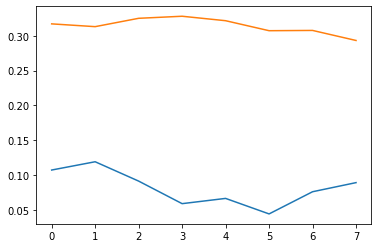

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total['Polarity Average'][:-1])
plt.plot(total['returns'][:-1])